<a href="https://colab.research.google.com/github/elyannmarih/TrafficPrediction/blob/main/notebooks/TrafficPrediction_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load preprocessed splits + stats

In [4]:
import numpy as np

# Load normalized train/val/test splits
train_norm = np.load("/content/drive/MyDrive/traffic_data/train_norm.npz")["data"]
val_norm   = np.load("/content/drive/MyDrive/traffic_data/val_norm.npz")["data"]
test_norm  = np.load("/content/drive/MyDrive/traffic_data/test_norm.npz")["data"]

# Load normalization stats (needed for denormalizing predictions later)
stats = np.load("/content/drive/MyDrive/traffic_data/normalization_stats.npz")
mean_per_sensor = stats["mean"]
std_per_sensor  = stats["std"]

print("Train:", train_norm.shape, "Val:", val_norm.shape, "Test:", test_norm.shape)


Train: (23990, 207, 3) Val: (3427, 207, 3) Test: (6855, 207, 3)


#Sliding windows

In [5]:
#Now we need to cut the time series into supervised learning samples:
#Input = last lookback steps (for example: 12 = 1 hour)
#Output = next horizon steps (for example: 3 = 15 min)

def create_sliding_windows(data, lookback=12, horizon=3):
    """
    data: [time, sensors, features]
    lookback: number of past steps to use as input
    horizon: number of future steps to predict
    """
    X, Y = [], []
    T = data.shape[0]

    for t in range(T - lookback - horizon):
        x_t = data[t:t+lookback, :, 0]   # only speed feature
        y_t = data[t+lookback:t+lookback+horizon, :, 0]
        X.append(x_t)
        Y.append(y_t)

    return np.array(X), np.array(Y)

# Example with train data
X_train, Y_train = create_sliding_windows(train_norm, lookback=12, horizon=3)
X_val, Y_val     = create_sliding_windows(val_norm, lookback=12, horizon=3)
X_test, Y_test   = create_sliding_windows(test_norm, lookback=12, horizon=3)

print("X_train:", X_train.shape, "Y_train:", Y_train.shape)


X_train: (23975, 12, 207) Y_train: (23975, 3, 207)


#Training baseline LSTM model

##Imports

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


##Convert sliding windows to PyTorch datasets

In [7]:
# Convert numpy arrays to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
Y_val_t   = torch.tensor(Y_val, dtype=torch.float32)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_t, Y_train_t), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, Y_val_t), batch_size=batch_size)


##Define LSTM model

In [8]:
class TrafficLSTM(nn.Module):
    def __init__(self, num_sensors=207, lookback=12, horizon=3, hidden_size=64, num_layers=1):
        super(TrafficLSTM, self).__init__()
        self.num_sensors = num_sensors
        self.horizon = horizon
        self.hidden_size = hidden_size

        # LSTM expects input: (batch, seq_len, features)
        self.lstm = nn.LSTM(input_size=num_sensors, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        # Fully connected: hidden_size → horizon * num_sensors
        self.fc = nn.Linear(hidden_size, horizon * num_sensors)

    def forward(self, x):
        # x: (batch, lookback, num_sensors)
        out, _ = self.lstm(x)  # (batch, lookback, hidden_size)
        last_hidden = out[:, -1, :]  # take last time step
        out = self.fc(last_hidden)   # (batch, horizon*num_sensors)
        out = out.view(-1, self.horizon, self.num_sensors)  # reshape
        return out


##Initialize model, loss, optimizer

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TrafficLSTM(num_sensors=207, lookback=12, horizon=3, hidden_size=64).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


##Training loop

In [10]:
def train_model(model, train_loader, val_loader, epochs=20):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X, Y in train_loader:
            X, Y = X.to(device), Y.to(device)
            optimizer.zero_grad()
            preds = model(X)
            loss = criterion(preds, Y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, Y in val_loader:
                X, Y = X.to(device), Y.to(device)
                preds = model(X)
                loss = criterion(preds, Y)
                val_loss += loss.item() * X.size(0)
        val_loss /= len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

train_model(model, train_loader, val_loader, epochs=20)


Epoch 1/20, Train Loss: 0.5173, Val Loss: 0.4525
Epoch 2/20, Train Loss: 0.3724, Val Loss: 0.3997
Epoch 3/20, Train Loss: 0.3316, Val Loss: 0.3744
Epoch 4/20, Train Loss: 0.3118, Val Loss: 0.3619
Epoch 5/20, Train Loss: 0.3000, Val Loss: 0.3551
Epoch 6/20, Train Loss: 0.2920, Val Loss: 0.3486
Epoch 7/20, Train Loss: 0.2862, Val Loss: 0.3473
Epoch 8/20, Train Loss: 0.2819, Val Loss: 0.3445
Epoch 9/20, Train Loss: 0.2787, Val Loss: 0.3407
Epoch 10/20, Train Loss: 0.2764, Val Loss: 0.3401
Epoch 11/20, Train Loss: 0.2742, Val Loss: 0.3373
Epoch 12/20, Train Loss: 0.2726, Val Loss: 0.3362
Epoch 13/20, Train Loss: 0.2712, Val Loss: 0.3373
Epoch 14/20, Train Loss: 0.2701, Val Loss: 0.3354
Epoch 15/20, Train Loss: 0.2691, Val Loss: 0.3350
Epoch 16/20, Train Loss: 0.2682, Val Loss: 0.3337
Epoch 17/20, Train Loss: 0.2674, Val Loss: 0.3338
Epoch 18/20, Train Loss: 0.2668, Val Loss: 0.3367
Epoch 19/20, Train Loss: 0.2662, Val Loss: 0.3321
Epoch 20/20, Train Loss: 0.2657, Val Loss: 0.3337


# Test

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

def evaluate_model(model, X_test, Y_test, mean, std):
    model.eval()
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    Y_test_t = torch.tensor(Y_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        preds = model(X_test_t).cpu().numpy()   # (samples, horizon, sensors)
        Y_true = Y_test_t.cpu().numpy()

    # Denormalize predictions and targets
    preds = preds * std + mean
    Y_true = Y_true * std + mean

    # Compute MAE and RMSE across all horizons and sensors
    mae = mean_absolute_error(Y_true.flatten(), preds.flatten())
    rmse = math.sqrt(mean_squared_error(Y_true.flatten(), preds.flatten()))

    return preds, Y_true, mae, rmse

preds, Y_true, mae, rmse = evaluate_model(model, X_test, Y_test, mean_per_sensor, std_per_sensor)
print(f"Test MAE: {mae:.4f}, Test RMSE: {rmse:.4f}")


Test MAE: 3.6989, Test RMSE: 6.0114


##Plot Predicted vs Actual (for one sensor)

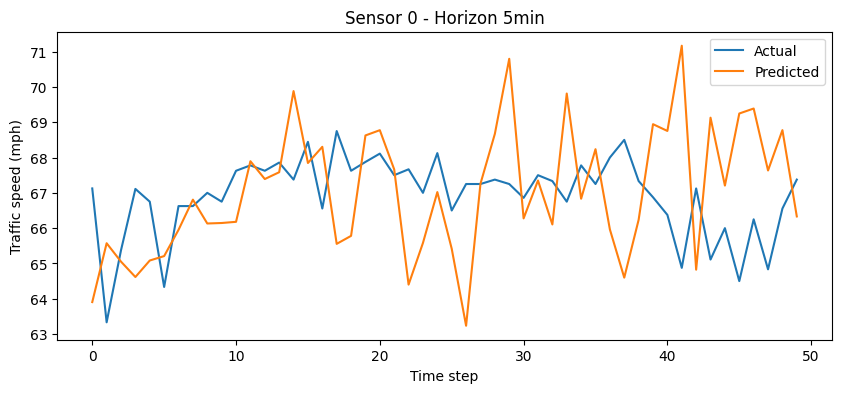

In [12]:
import matplotlib.pyplot as plt

# Pick one sensor (e.g., sensor 0)
sensor_id = 0

# Compare first 50 predictions for horizon=1 (5 minutes ahead)
plt.figure(figsize=(10,4))
plt.plot(Y_true[:50, 0, sensor_id], label="Actual")
plt.plot(preds[:50, 0, sensor_id], label="Predicted")
plt.xlabel("Time step")
plt.ylabel("Traffic speed (mph)")
plt.title(f"Sensor {sensor_id} - Horizon 5min")
plt.legend()
plt.show()


##Evaluate by horizons

In [13]:
#Metrics at different horizons (5, 15, 30 min). We can slice predictions:
def evaluate_by_horizon(preds, Y_true, mean, std):
    horizons = preds.shape[1]  # for example: 3 = 15min
    metrics = {}
    for h in range(horizons):
        pred_h = preds[:, h, :] * std + mean
        true_h = Y_true[:, h, :] * std + mean
        mae = mean_absolute_error(true_h.flatten(), pred_h.flatten())
        rmse = math.sqrt(mean_squared_error(true_h.flatten(), pred_h.flatten()))
        metrics[h+1] = (mae, rmse)
    return metrics

metrics = evaluate_by_horizon(preds, Y_true, mean_per_sensor, std_per_sensor)
for h, (mae, rmse) in metrics.items():
    print(f"Horizon {h}: MAE={mae:.4f}, RMSE={rmse:.4f}")


Horizon 1: MAE=42.3508, RMSE=78.2880
Horizon 2: MAE=44.0181, RMSE=82.8745
Horizon 3: MAE=45.6411, RMSE=87.2815
